# Auto-Encoderを用いた特徴ベクトルの分解

特徴ベクトル$f$をAuto-Encoderを用いて，識別空間のベクトル$u$とカーネル空間のベクトル$v=f-u$に分解するプログラム

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

In [2]:
# デバイスの設定 (GPUが利用可能であればGPUを使用)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fashion MNIST データの読み込みとデータ拡張
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 26.4M/26.4M [00:14<00:00, 1.78MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 109kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.97MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 28.9MB/s]


In [3]:
# CNNモデルの定義 (Encoder + Classifier + Decoder)
class CNNAutoencoder(nn.Module):
    def __init__(self, feature_dim=128, bottleneck_dim=32):
        super(CNNAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, feature_dim)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(feature_dim, 10)  # Classifier

        # Decoder
        self.decoder = nn.Linear(10, feature_dim)  # Decoder: 10次元 -> feature_dim

    def forward(self, x):
        # Encoder
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        feature_vector = self.relu3(self.fc1(x))

        # Classifier
        class_output = self.fc2(feature_vector)

        # Decoder
        reconstructed_feature_vector = self.decoder(class_output)

        return class_output, feature_vector, reconstructed_feature_vector


In [4]:
# モデル、損失関数、最適化手法の定義
feature_dim = 64
cnn_autoencoder_model = CNNAutoencoder(feature_dim).to(device)

criterion_cnn = nn.CrossEntropyLoss()
criterion_autoencoder = nn.MSELoss()
optimizer = optim.Adam(cnn_autoencoder_model.parameters(), lr=0.001)

lambda_reg = 0.1  # 正則化の強さ

# 学習
num_epochs = 10
train_losses = []
reconstruction_losses = []

for epoch in range(num_epochs):
    cnn_autoencoder_model.train()
    epoch_train_loss = 0.0
    epoch_reconstruction_loss = 0.0
    num_batches = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # 順伝播
        outputs, feature_vectors, reconstructed_feature_vector = cnn_autoencoder_model(images)

        # 損失の計算
        loss_classification = criterion_cnn(outputs, labels)
        loss_reconstruction = criterion_autoencoder(reconstructed_feature_vector, feature_vectors) #特徴ベクトルを再構成するように修正

        # 正則化項を損失に加える
        loss = loss_classification + lambda_reg * loss_reconstruction

        # 勾配計算とパラメータ更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss_classification.item()
        epoch_reconstruction_loss += loss_reconstruction.item()
        num_batches += 1

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Classification Loss: {loss_classification.item():.4f}, Reconstruction Loss: {loss_reconstruction.item():.4f}, Combined Loss: {loss.item():.4f}')

    train_losses.append(epoch_train_loss / num_batches)
    reconstruction_losses.append(epoch_reconstruction_loss / num_batches)

print('Finished Training.')


Epoch [1/10], Step [100/938], Classification Loss: 0.6640, Reconstruction Loss: 1.3573, Combined Loss: 0.7997
Epoch [1/10], Step [200/938], Classification Loss: 0.4613, Reconstruction Loss: 0.7388, Combined Loss: 0.5352
Epoch [1/10], Step [300/938], Classification Loss: 0.5240, Reconstruction Loss: 0.4107, Combined Loss: 0.5651
Epoch [1/10], Step [400/938], Classification Loss: 0.3923, Reconstruction Loss: 0.2623, Combined Loss: 0.4185
Epoch [1/10], Step [500/938], Classification Loss: 0.3847, Reconstruction Loss: 0.1982, Combined Loss: 0.4045
Epoch [1/10], Step [600/938], Classification Loss: 0.2913, Reconstruction Loss: 0.1853, Combined Loss: 0.3099
Epoch [1/10], Step [700/938], Classification Loss: 0.3364, Reconstruction Loss: 0.1451, Combined Loss: 0.3509
Epoch [1/10], Step [800/938], Classification Loss: 0.4115, Reconstruction Loss: 0.1466, Combined Loss: 0.4262
Epoch [1/10], Step [900/938], Classification Loss: 0.1839, Reconstruction Loss: 0.1251, Combined Loss: 0.1965
Epoch [2/1

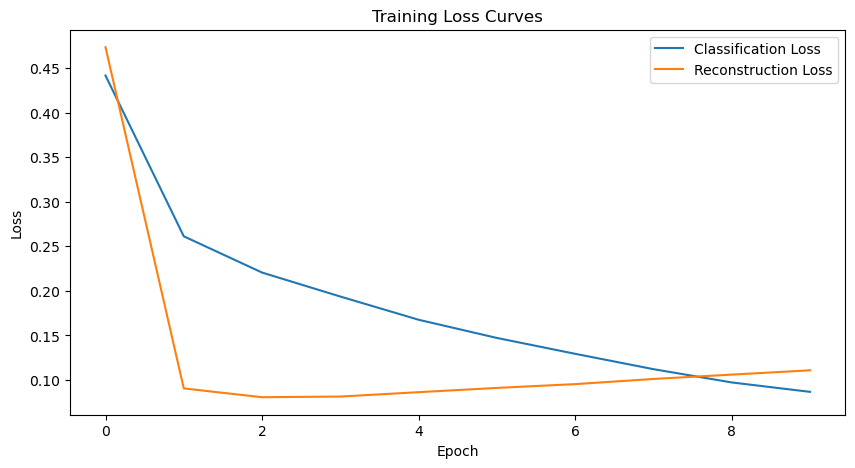

In [5]:
# 学習曲線のプロット
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Classification Loss')
plt.plot(reconstruction_losses, label='Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.show()


In [6]:
# 評価
cnn_autoencoder_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs, _, _ = cnn_autoencoder_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the CNN on the test images: {100 * correct / total:.2f} %')


Accuracy of the CNN on the test images: 91.67 %


In [7]:

# 分解関数の定義 (ここではAutoencoderによる分解は行わないので、恒等写像として定義)
def decompose_feature_vector(feature_vector):
    u = torch.zeros_like(feature_vector) # ゼロベクトル
    v = feature_vector # 特徴ベクトルそのもの
    return u, v

# 訓練データに対する特徴ベクトルと分解ベクトルの取得
cnn_autoencoder_model.eval()
feature_vectors = []
u_vectors = []
v_vectors = []
labels_list = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs, f, _ = cnn_autoencoder_model(images)
        u, v = decompose_feature_vector(f)

        feature_vectors.append(f.cpu().numpy())
        u_vectors.append(u.cpu().numpy())
        v_vectors.append(v.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

feature_vectors = np.concatenate(feature_vectors)
u_vectors = np.concatenate(u_vectors)
v_vectors = np.concatenate(v_vectors)
labels_list = np.concatenate(labels_list)


In [8]:
print('Feature vectors shape:', feature_vectors.shape)
print('U vectors shape:', u_vectors.shape)
print('V vectors shape:', v_vectors.shape)
print('Labels shape:', labels_list.shape)

Feature vectors shape: (60000, 64)
U vectors shape: (60000, 64)
V vectors shape: (60000, 64)
Labels shape: (60000,)


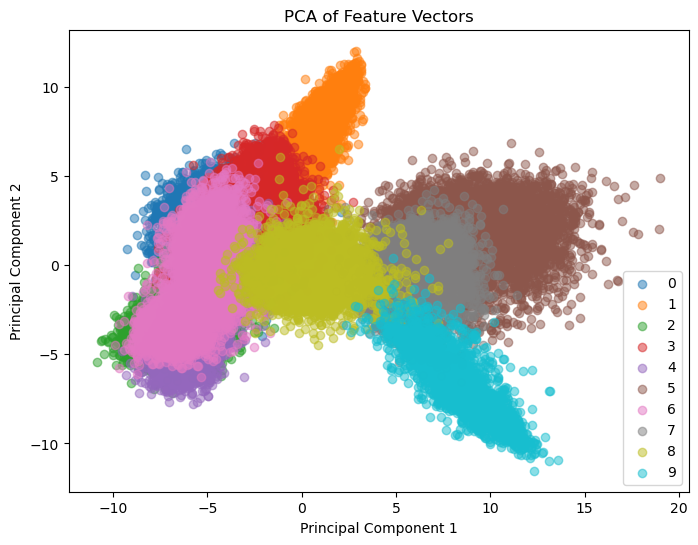

/home/kurita/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


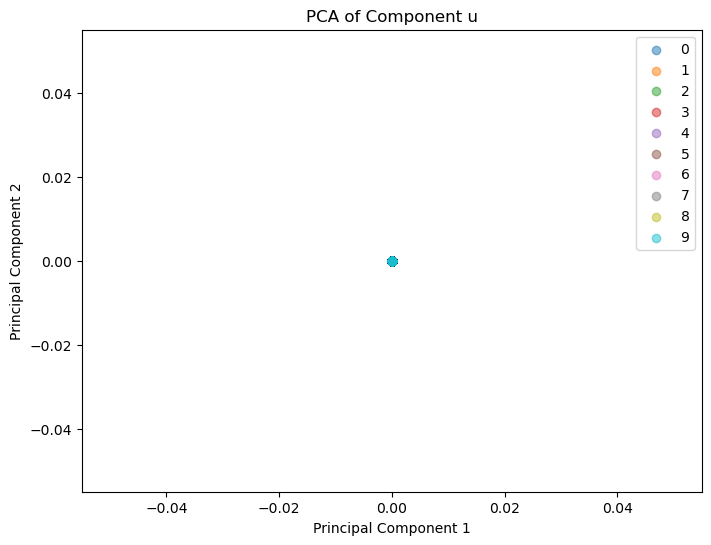

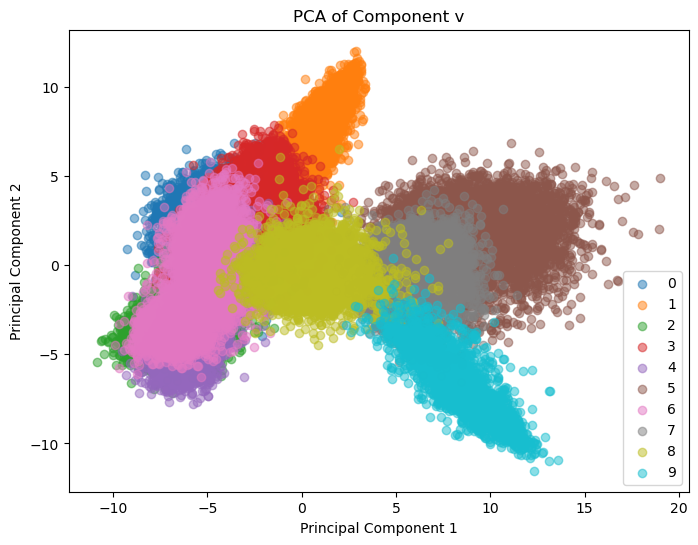

In [9]:

# PCAによる次元削減とプロット
def plot_pca(data, labels, title):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)

    plt.figure(figsize=(8, 6))
    for i in range(10):  # FashionMNISTのクラス数
        plt.scatter(pca_result[labels == i, 0], pca_result[labels == i, 1], label=str(i), alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.legend()
    plt.show()

# プロット
plot_pca(feature_vectors, labels_list, 'PCA of Feature Vectors')
plot_pca(u_vectors, labels_list, 'PCA of Component u')
plot_pca(v_vectors, labels_list, 'PCA of Component v')